In [322]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from scipy import stats
from scipy import optimize
import pandas as pd

Sources:

https://cds.cern.ch/record/2257069?ln=en

https://atlas.physicsmasterclasses.org/en/zpath_lhcphysics2.htm

inspiração para filtros:

https://github.com/Introducao-AnaliseDados-FAE/IntroducaoAnalisedeDadosFAE-2024_02/blob/main/material/aula_8/aulaMatheusCosta_26Nov2024.pdf


fonte para os labels dos dados:

https://cms-opendata-workshop.github.io/workshop2024-lesson-physics-objects/aio.html

para luminosidade (?):

https://cms-opendata-guide.web.cern.ch/analysis/lumi/

Z boson mass:

https://en.wikipedia.org/wiki/W_and_Z_bosons

In [323]:
FILTER_MASS = True
MASS_MIN = 60
MASS_MAX = 120
BINS = 30
DPI = 115

def inv_mass(ak_vec1: ak.Array, ak_vec2: ak.Array) -> ak.Array:
    return ak.flatten(np.sqrt(
        2 * ak_vec1.pt * ak_vec2.pt * (np.cosh(ak_vec1.eta - ak_vec2.eta) - np.cos(ak_vec1.phi - ak_vec2.phi))
    ))

def expand(ak_array: ak.Array) -> tuple[ak.Array, ak.Array]:
    pairs = ak.combinations(ak_array, 2)
    return ak.unzip(pairs)

def inv_mass_expand(ak_array: ak.Array) -> ak.Array:
    vec1, vec2 = expand(ak_array)
    mass = inv_mass(vec1, vec2)
    if FILTER_MASS:
        mass = mass[(mass > MASS_MIN) & (mass < MASS_MAX)]
    return mass

def generete_data(file_path: str, branches: list[str]) -> ak.Array:
    with uproot.open(file_path) as file:
        tree = file['Events']
        arrays = {branch.split("_")[-1].lower(): tree[branch].array() for branch in branches}
    return ak.zip(arrays)

def hist_plot(ak_array: Union[ak.Array, np.ndarray],
              column_name: str,
              display_name: str = None, **kwargs):
    plt.hist(ak.flatten(ak_array[column_name]) if isinstance(ak_array, ak.Array) else ak_array, **kwargs)
    plt.xlabel(display_name if display_name else column_name)
    plt.ylabel("Eventos")

def generate_points(mass, bins=BINS, bins_edge_return=False):
    hist_counts, bin_edges = np.histogram(mass, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    if bins_edge_return:
        return bin_centers, hist_counts, bin_edges
    return bin_centers, hist_counts

Fonte dos dados:

https://opendata.cern.ch/record/35669

https://opendata.cern.ch/record/30522

In [324]:
data = "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/30000/0082C29D-E74C-024A-BE9B-97B29EE7A4A2.root" 
realdata = "root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/05DD095C-F6C3-9A4F-9FB3-348A5A6403D5.root"

Processo que queremos estudar

![alt text](image-1.png)

colunas que iremos selecionar:

In [325]:
branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "nMuon", "Muon_tkRelIso", "Muon_sip3d"]

# significado de cada coluna:
# muon_pt: Momento transverso do múon
# muon_eta: Pseudorapidez do múon - invariante sob transformações de Lorentz na direção do feixe.
# muon_phi: Ângulo azimutal do múon
# muon_charge: Carga do múon (1 ou -1)
# nMuon: Número de múons no evento
# muon_tkRelIso: Isolamento relativo do múon
# muon_sip3d: Parâmetro de impacto do múon - se veio de um vérice primário ou de um decaimento secundário


In [5]:
vec_real = generete_data(realdata, branches)
vec = generete_data(data, branches)

quantidade de dados:

In [6]:
print(f"Real data: {len(vec_real)}")
print(f"Simulated data: {len(vec)}")

Real data: 2315223
Simulated data: 1933726


# Plots

aqui vamos plotar a comparação entre os dados simulados (MC) e os dados reais coletados pelo LHC

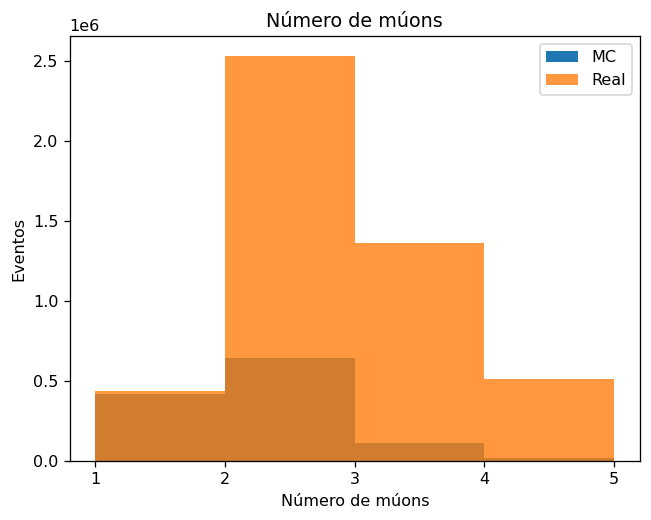

In [151]:
plt.figure(dpi=DPI)
hist_plot(vec, "nmuon", "Número de múons", label="MC",bins=4, range=(1, 5))
hist_plot(vec_real, "nmuon", "Número de múons", label="Real", alpha=0.8, bins=4, range=(1, 5))
plt.xticks(range(1, 6))
plt.title("Número de múons")
plt.legend()
plt.show()

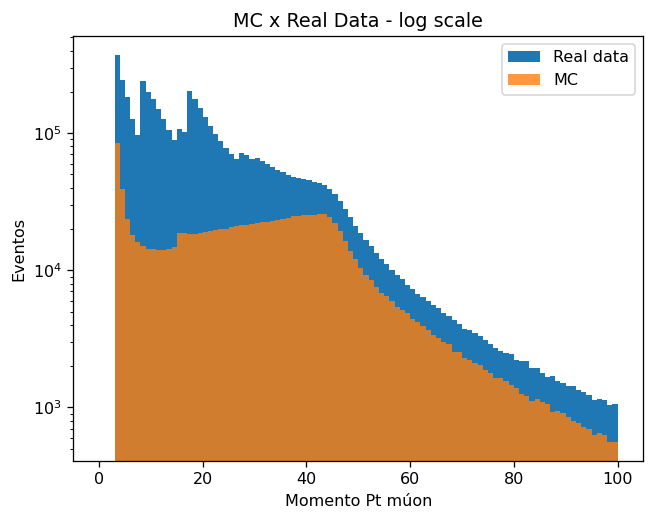

In [152]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="Real data")
hist_plot(vec, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

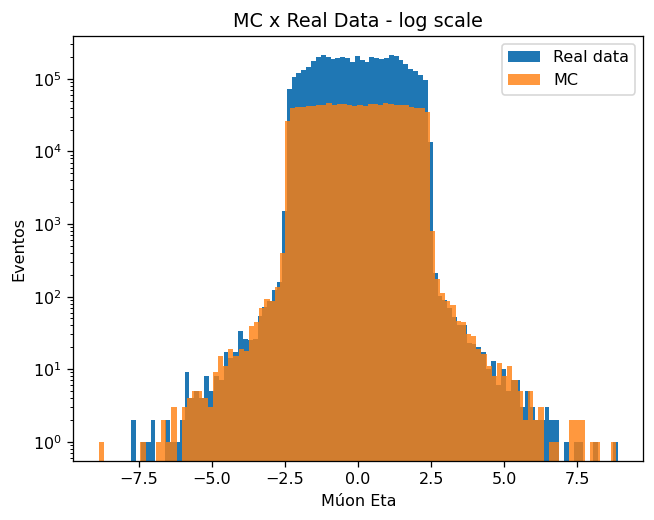

In [153]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "eta" , "Múon Eta", bins=100, log=True, label="Real data")
hist_plot(vec, "eta" , "Múon Eta", bins=100, log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

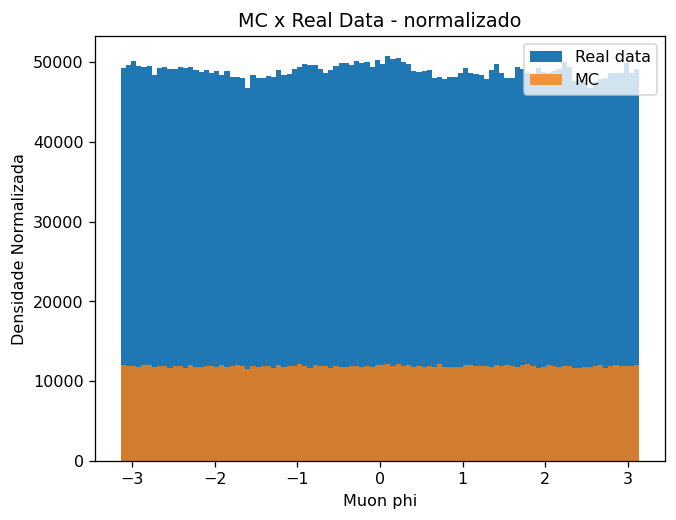

In [294]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "phi" , "Muon phi", bins=100, label="Real data",)
hist_plot(vec, "phi" , "Muon phi", bins=100, label="MC", alpha=0.8)
plt.title("MC x Real Data - normalizado")
plt.ylabel("Densidade Normalizada")
plt.legend()
plt.show()

In [155]:
mass_real = inv_mass_expand(vec_real)
mass = inv_mass_expand(vec)

bin_centers, hist_counts = generate_points(mass_real)

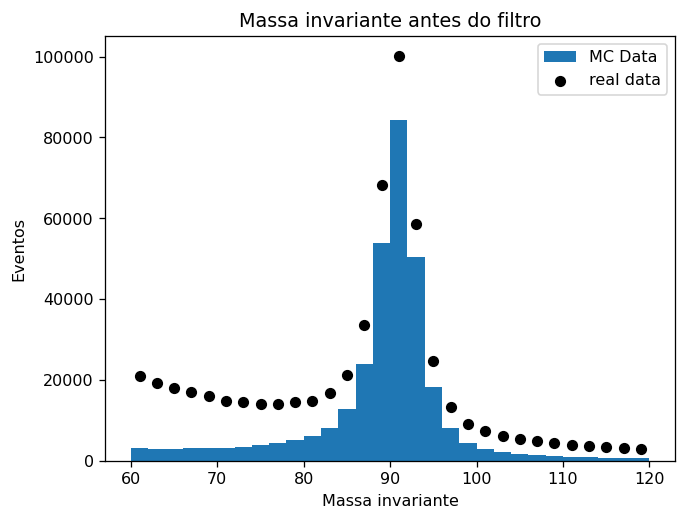

In [156]:
plt.figure(dpi=DPI)
plt.hist(mass, bins=BINS, label="MC Data")
plt.scatter(bin_centers, hist_counts, label="real data", color="black")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.title("Massa invariante antes do filtro")
plt.legend()
plt.show()

# Aplicando filtros

O evento que queremos estudar é:

Z -> mu+ mu-

Então:

Exemplo de formas de filtrar os dados:

In [157]:
vec_real[0: 5]

<Array [[{pt: 16.7, eta: ..., ...}, ...], ...] type='5 * var * {pt: float32...'>

In [158]:
vec_real[vec_real.pt > 20][0: 5]

<Array [[], [{pt: 27.2, ...}], ..., [...], []] type='5 * var * {pt: float32...'>

In [159]:
vec_real.pt > 20

<Array [[False, False, False], ..., [True, ...]] type='2315223 * var * bool'>

In [160]:
# filtrando para garantir que vamos ter apenas 2 muons
filtered_real = vec_real[ak.num(vec_real) == 2]

# como só temos 2 muons, se somar a carga deles e der 0, significa que são de cargas opostas
filtered_real = filtered_real[ak.sum(filtered_real.charge, axis=1) == 0]

# filtrando para garantir que o pt seja maior que 20
filtered_real = filtered_real[ak.all(filtered_real.pt > 20, axis=1)]

# fiiltros em relação aos dados
filtered_real = filtered_real[filtered_real.tkreliso < 4]
filtered_real = filtered_real[filtered_real.sip3d < 4]
filtered_real = filtered_real[ak.all(filtered_real.eta < 2.1, axis=1)]
filtered_real = filtered_real[ak.all(filtered_real.eta > -2.1, axis=1)]


# realizando o mesmo processo para os dados simulados
filtered = vec[ak.num(vec) == 2]
filtered = filtered[ak.sum(filtered.charge, axis=1) == 0]
filtered = filtered[ak.all(filtered.pt > 20, axis=1)]
filtered = filtered[filtered.tkreliso < 4]
filtered = filtered[filtered.sip3d < 4]
filtered = filtered[ak.all(filtered.eta < 2.1, axis=1)]
filtered = filtered[ak.all(filtered.eta > -2.1, axis=1)]

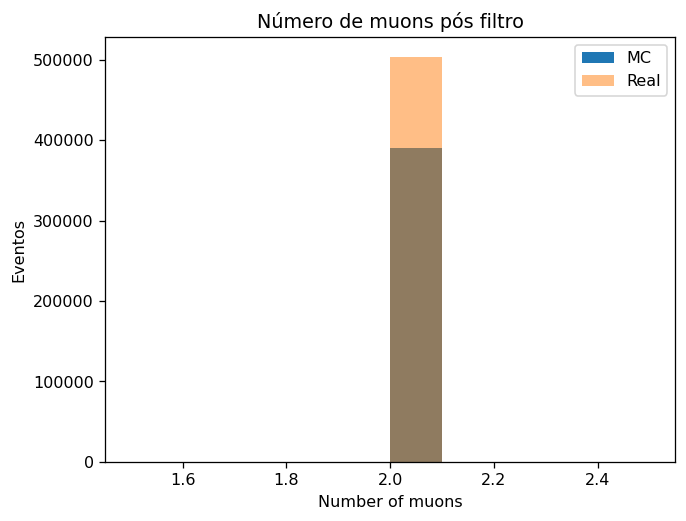

In [161]:
plt.figure(dpi=DPI)
hist_plot(filtered, "nmuon", "Number of muons", label="MC")
hist_plot(filtered_real, "nmuon", "Number of muons", label="Real", alpha=0.5)
plt.title("Número de muons pós filtro")
plt.legend()
plt.show()

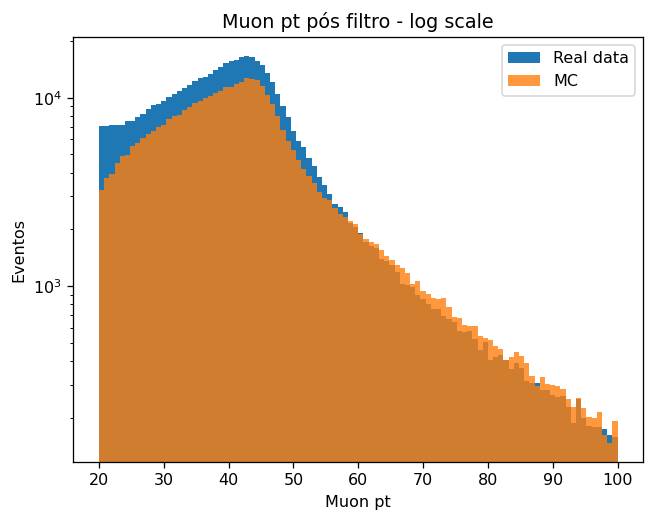

In [162]:
plt.figure(dpi=DPI)
hist_plot(filtered_real, "pt" , "Muon pt", bins=100, range=(20, 100), log=True, label="Real data")
hist_plot(filtered, "pt" , "Muon pt", bins=100, range=(20, 100), log=True, label="MC", alpha=0.8)
plt.title("Muon pt pós filtro - log scale")
plt.legend()
plt.show()

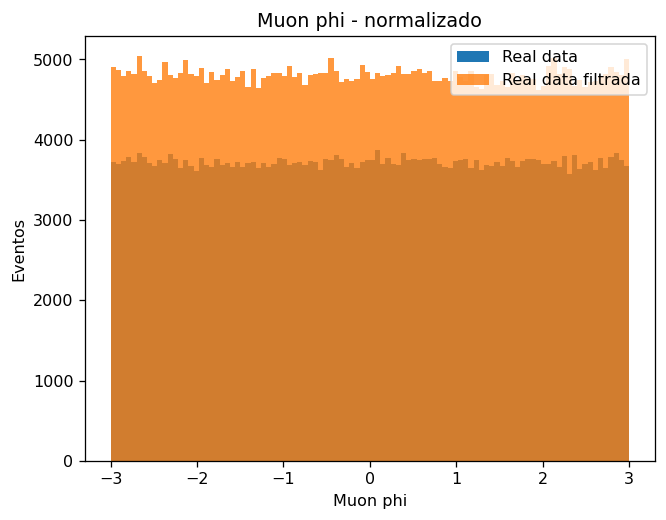

In [321]:
plt.figure(dpi=DPI)
hist_plot(filtered, "phi", "Muon phi", bins=100, range=(-3, 3), label="Real data")
hist_plot(filtered_real, "phi", "Muon phi", bins=100, range=(-3, 3), label="Real data filtrada", alpha=0.8)
plt.title("Muon phi - normalizado")
plt.legend()
plt.show()

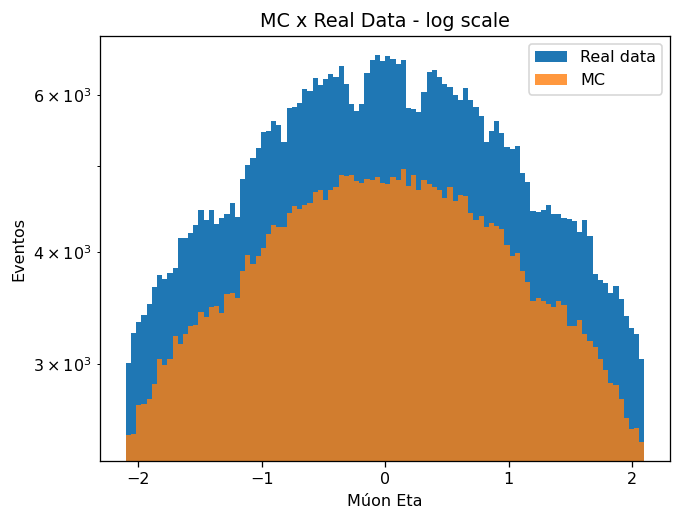

In [164]:
plt.figure(dpi=DPI)
hist_plot(filtered_real, "eta" , "Múon Eta", bins=100, log=True, label="Real data")
hist_plot(filtered, "eta" , "Múon Eta", bins=100, log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

In [165]:
mass_real_filtered = inv_mass_expand(filtered_real)
mass_filtered = inv_mass_expand(filtered)

bin_centers_filtered, hist_counts_filtered = generate_points(mass_real_filtered)


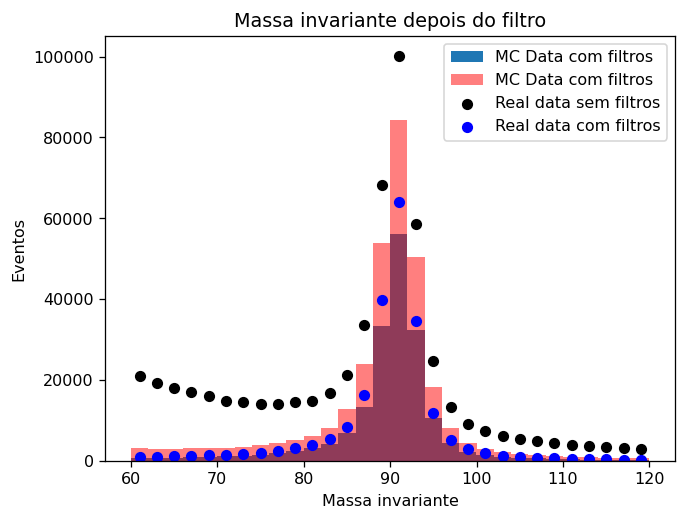

In [297]:
plt.figure(dpi=DPI)
plt.hist(mass_filtered, bins=BINS, label="MC Data com filtros")
plt.hist(mass, bins=BINS, label="MC Data com filtros", alpha=0.5, color='red', )
plt.scatter(bin_centers, hist_counts, label="Real data sem filtros", color="black",)
plt.scatter(bin_centers_filtered, hist_counts_filtered, color="blue", label="Real data com filtros")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.legend()
plt.title("Massa invariante depois do filtro")
plt.show()

Podemos agora fazer o cálculo:

In [304]:
def func(x, a, b, c, d, e):
    x = np.asarray(x)
    return a * x + b + c * stats.norm.pdf(x, loc=d, scale=e)

def func(x, a, b, c, d, e, beta, m):
    x = np.asarray(x)
    return a * x + b + c * stats.crystalball.pdf(x, beta, m, loc=d, scale=e)

In [314]:
BINS = 90

In [315]:
bin_centers_reg, hist_counts_reg, bins_edge_reg = generate_points(mass_real_filtered, bins=BINS, bins_edge_return=True)

In [316]:
a = 0 
b = np.mean(hist_counts_reg) 
c = max(hist_counts_reg) 
d = np.mean(mass_real_filtered) 
e = np.std(mass_real_filtered) 
beta = 2
m = 2

In [317]:
popt, pcov = optimize.curve_fit(
    func,
    bin_centers_reg,
    hist_counts_reg,
    p0=[a, b, c, d, e,beta, m], #  
    maxfev=10000
)

In [318]:
popt

array([-1.75309196e+00,  5.94162159e+02,  1.18489392e+05,  9.09165567e+01,
        1.92283508e+00,  1.07078534e+00,  3.32566537e+00])

In [310]:
Z_achado = round(popt[3], 2)

In [311]:
# do resultado acima, sabemos que 90.8 GeV seria aproximadamente a massa do Z boson.
# pela nossa fonte, vemos que: 91.1876 GeV é a massa do Z boson

In [288]:
columns_and_index = ["a", "b", "c", "d", "e"] # "beta", "m"

In [289]:
pcov_df = pd.DataFrame(pcov, columns=columns_and_index, index=columns_and_index)
pcov_df

,a,b,c,d,e
a,429.500405,-3.857330e+04,-5.008713e+03,-0.095322,-0.022543
b,-38573.297170,3.622507e+06,-1.359561e+06,8.554987,-6.100030
c,-5008.713361,-1.359561e+06,1.086045e+08,1.462920,487.662792
d,-0.095322,8.554987e+00,1.462920e+00,0.005370,0.000010
e,-0.022543,-6.100030e+00,4.876628e+02,0.000010,0.005744


In [319]:
x_fit = np.linspace(bins_edge_reg[0], bins_edge_reg[-1], BINS)
y_fit = func(x_fit, *popt)

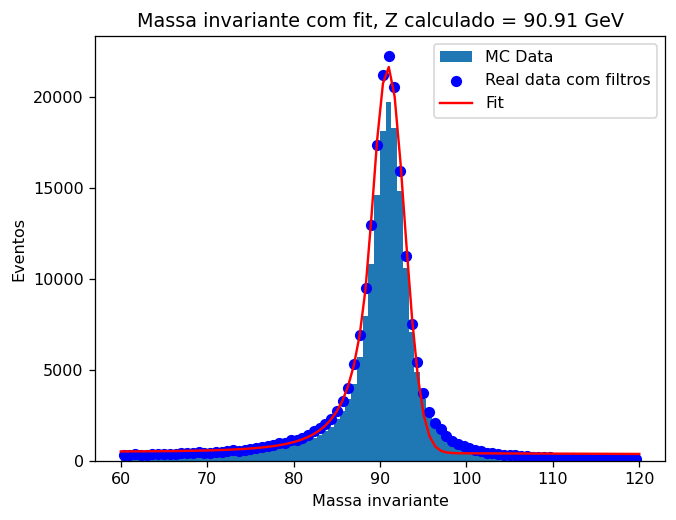

In [320]:
plt.figure(dpi=DPI)
plt.hist(mass_filtered, bins=BINS, label="MC Data", )
plt.scatter(bin_centers_reg, hist_counts_reg, color="blue", label="Real data com filtros")
plt.plot(x_fit, y_fit, label="Fit", color="red")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.legend()
plt.title(f"Massa invariante com fit, Z calculado = {Z_achado} GeV")
plt.show()

In [292]:
err_percent = abs(Z_achado - 91.1876)/91.1876 * 100
err_percent

0.3921585829652332

In [293]:
compatibilidade = abs(Z_achado - 91.1876) / pcov[3][3]
compatibilidade

66.59291069616954

# FINAL DO NOTEBOOK